In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import sys
import importlib
import pandas as pd
from matplotlib.colors import ListedColormap
import matplotlib.gridspec as gridspec

# personal imports
from utils_orbs.orb_paths import SetupPaths
import utils_orbs.readsubfHDF5Py3 as readSub
# from utils.read_group_cats import ReadCats
from utils_orbs.merger_trees import TraceMergerTree
from utils_orbs.readMergerHistoryFiles import FindHistory
from utils_orbs.vectorCorrection import vectorCorrection as vector

paths = SetupPaths()

imported h5py...
modules seem to have loaded?


In [2]:
plt.show();
plt.rcParams.update({'font.size':20,"xtick.direction":"in","ytick.direction":"in", 
                     "xtick.top":True, "ytick.right":True,"text.usetex":False,
                     "xtick.labelsize":18,"ytick.labelsize":18,
                     "xtick.minor.top":True, "ytick.minor.right":True,
                     "xtick.minor.visible": True,
                     "ytick.minor.visible": True})

todo: make this a class if you want, but like... later

In [3]:
def make_colorarray(color_val, f):
    """
    creates the correctly scaled array of values from 0,1 for one rgb val
    ---
    inputs: 
    - color_val: float
        float representing one of the r, g, or b values of desired custom colormap
    - f: float
        the location of custom color in colorbar (from 0-1)  
        f = 1, color scale will be from white to rgb
        f = 0, color scale will be from rgb to black
        f = 0.5 - 1, color scale slowly transitions from white to color, then quickly from color to black
        f = 0 - 0.5, color scale quickly transition from white to color, then slowly from color to black
        recommend 0.25 for sparse data with low vals, or 0.75 for sparse at higher vals
    --- 
    returns: 
    - array of length 256, containing linearly spaced values from 0-f and f-1
    ---
    Note: if f*N is not an integer, it will be rounded down to the nearest int
    """
    
    N = 256
    f_val = int(N * f)
    
    white_to_color = np.linspace(1, color_val, f_val)
    color_to_black = np.linspace(color_val, 0, N-f_val)
    
    combined = np.concatenate((white_to_color, color_to_black))
    return combined

def make_colormap(rgb_list, where_color):
    """ 
    creates colormap with alpha = 0
    ---
    inputs: 
    - rgb_list: list or array
                contains 3 elements for the r, g, and b color vals respectively
    - where_color: float in [0,1]
                the location of the colorbar where the color is placed
                if where_color = 1, color scale will be from white to rgb
                if where_color = 0, color scale will be from rgb to black
                if where_color = f, color scale will go from white to rgb at 
                the fraction f of the total colorbar size, then rgb to black
    --- 
    returns:
    - ListedColormap 
    """
        # add below later when you have time
        #     if where_color
    
        #     else: 
        #         raise TypeError("arg 'where_color' should be a float from 0-1")
    
    N = 256 # rgb 
    vals = np.ones((N, 4))
    
    # replace the r, b, and g columns with rgb-specific arrays
    for i in range(3):
        vals[:, i] = make_colorarray(rgb_list[i], where_color)
        
    try: 
        map_object = ListedColormap(vals)
    except NameError:
        err_string = "You have not imported the required matplotlib module.\n\
                      Please add 'from matplotlib.colors import ListedColormap'"
        print(err_string)
    
    return map_object


In [4]:
# defining color palette & colormaps for plotting
palette = {"low":"olive", "high":"salmon", 
           "difference":"#2C1D11", "difference2":"#464646"}    
        
g_rgb = [128/256, 128/256, 38/256] # green rgb vals
p_rgb = [234/256, 134/256, 119/256] # pink rgb vals

green_map = make_colormap(g_rgb, 0.25)
pink_map = make_colormap(p_rgb, 0.25)

# Import data

In [7]:
low = {}
f = h5py.File(f"{paths.path_data}hail-mary/unique_orbits.hdf5",'r')
for key, val in f.items():
    low[key] = np.array(val)
f.close()

high = {}
f = h5py.File(f"{paths.path_data}big-bad/unique_orbits_massive.hdf5",'r')
for key, val in f.items():
    high[key] = np.array(val)
f.close()

f = h5py.File(f"{paths.path_data}snapshot_data.hdf5",'r')
convert = {}
for key, val in f.items():
    convert[key] = np.array(val)
f.close()

# Merger time vs. separation (2d hist)

In [30]:
def add_2dhist(data, snapshot, ax, cmap=green_map, vmax=20):
    lbt_at_snap = convert["Lookback Time"][snapshot]
    seps_at_snap = data['Separations'][:,snapshot]
    postinfall_at_snap = data['InfallSnapshot'] <= snapshot # infall snapshot must be = or prior to 40
    merge_later = data['MergeSnapshot'] > snapshot # merger snapshot must be after

    postinfall_willmerge = postinfall_at_snap&merge_later # merging pairs 
    seps_will_merge = np.where(postinfall_willmerge, seps_at_snap, np.nan)

    mask_lower10 = (seps_will_merge > 10)

    seps_for_hist = seps_will_merge[mask_lower10]
    number_seps = len(seps_for_hist)
    
    mergesnap = data['MergeSnapshot'][mask_lower10]
    mergetimes = convert["Lookback Time"][mergesnap]
    mt_for_hist = lbt_at_snap - mergetimes
        
    kwargs = {"range":[[0,300],[0,8]],
              "bins": [int(15),int(16)],
              "cmap":cmap,
              "weights":100*np.ones(number_seps)/number_seps,
              "vmin":0,
              "vmax":vmax
             }
    
    h,_,_,im0 = ax.hist2d(seps_for_hist, mt_for_hist,**kwargs)

    return h, im0, number_seps


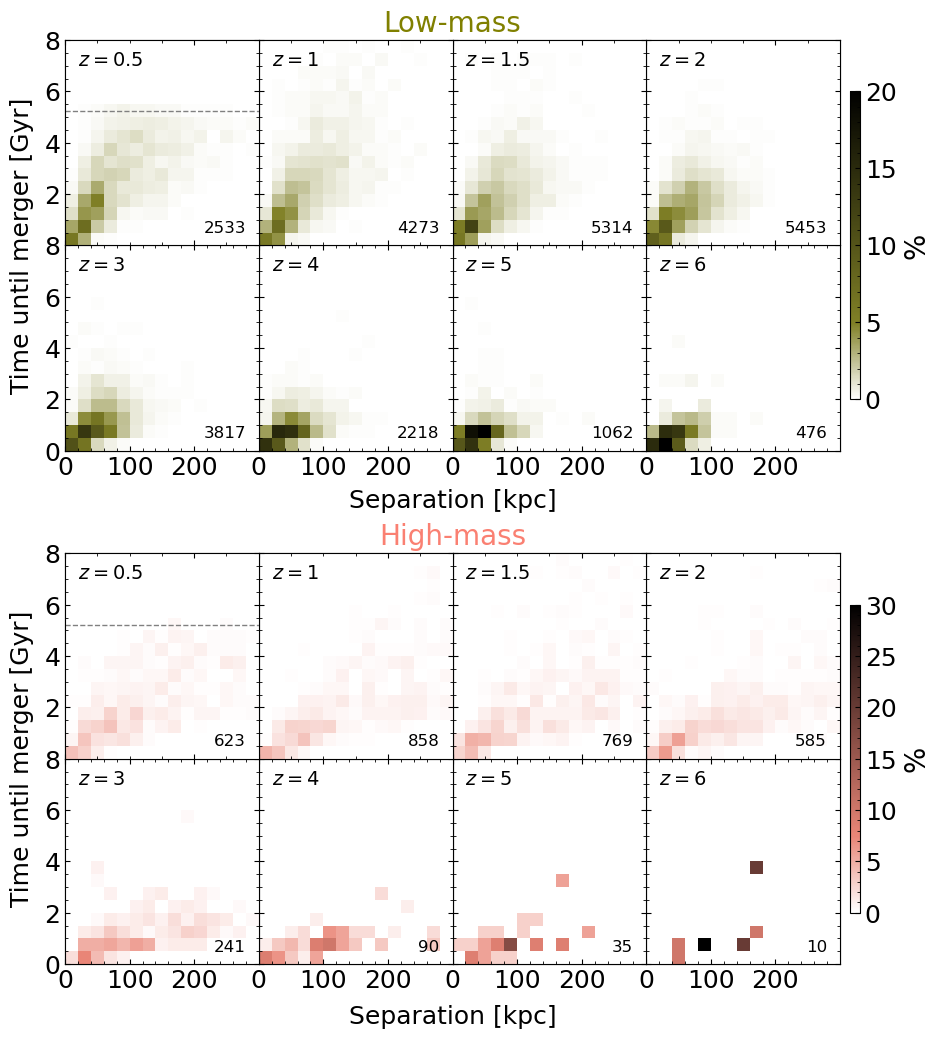

In [68]:
fig = plt.figure(figsize=(10, 12))
outer = gridspec.GridSpec(2, 1, wspace=0.2, hspace=0.25)

title_string = ["Low-mass","High-mass"]
title_color = [palette['low'],palette['high']]

redshift = [[0.5,1,1.5,2],[3,4,5,6]]
snaps = [[67,50,40,33],[25,21,17,13]]
timeleft = convert["Lookback Time"][67]
locs = {}

for outnum in range(2):
    inner = gridspec.GridSpecFromSubplotSpec(2, 4,
                    subplot_spec=outer[outnum], wspace=0, hspace=0)

    ax = plt.Subplot(fig, outer[outnum])
    ax.set_title(title_string[outnum], color=title_color[outnum], fontsize=20)
    ax.set_xticks([])
    ax.set_yticks([])
    
    fig.add_subplot(ax)
    locs[outnum] = ax.get_position()
    
    for rownum in range(2)[::-1]:        
        for colnum in range(4)[::-1]:
            ax = plt.Subplot(fig, inner[rownum,colnum])
            ax.set(ylim=(0,8),xlim=(0,300))
            snapnum = snaps[rownum][colnum]
            
            if outnum == 0:
                _,grbar, numseps = add_2dhist(low, snapnum, ax)
                
            elif outnum == 1:
                _,pnkbar, numseps = add_2dhist(high, snapnum, ax, cmap=pink_map, vmax=30)
            
            ax.text(20,7, r'$z=%s$' % (redshift[rownum][colnum]),fontsize=14)

            ax.text(280,0.5, r'%i' % (numseps),fontsize=12,ha='right')
#             ax.text(280,0.4, r'Pairs',fontsize=12,ha='right')
            
            if (colnum == 0)&(rownum == 0):
                ax.axhline(timeleft, linestyle="dashed", lw=1, color='grey')
            
            # managing ticks:
            if colnum != 0:
                ax.tick_params(labelleft=False)    
            
            if rownum != 1:
                ax.tick_params(labelbottom=False)    
                ax.set_yticks(ticks=np.arange(2,9,2))
                
            else: 
                ax.set_xticks(ticks=[0, 100, 200])
            ax.set_ylabel(" ")
            ax.set_xlabel(" ")
            
            fig.add_subplot(ax)

# locations : 
xloc = locs[0].x0+((locs[0].x1-locs[0].x0)/2)    
top_yheight = locs[0].y1-locs[0].y0
top_yloc = locs[0].y0+(top_yheight/2)
bottom_yheight = locs[1].y1-locs[1].y0
bottom_yloc = locs[1].y0+(bottom_yheight/2)

# colorbar:
loc_xcax = 0.91
loc_ycax = locs[0].y0+top_yheight/8
height_cax = 6*top_yheight/8
width_cax = 0.01
colorbar_kwargs = {"aspect":30, "location":"right",
                   "shrink":0.8,"pad":0.01,"label":"%"}

cax = fig.add_axes([loc_xcax, locs[0].y0+top_yheight/8, width_cax, height_cax])
fig.colorbar(grbar, cax=cax, **colorbar_kwargs)

cax = fig.add_axes([loc_xcax, locs[1].y0+top_yheight/8, width_cax, height_cax])
fig.colorbar(pnkbar, cax=cax, **colorbar_kwargs)


## labels:
xlabel_kwargs = {"fontsize":18, 
                 "ha":'center', 
                 "weight":'medium'}

ylabel_kwargs = {"rotation":'vertical',
                 "fontsize":18, 
                 "va":'center', 
                 "weight":'medium'}

# top plot:  
fig.text(0.07, top_yloc, r"Time until merger [Gyr]", **ylabel_kwargs) 
fig.text(xloc, 0.49, "Separation [kpc]", **xlabel_kwargs) 

# bottom plot: 
fig.text(0.07, bottom_yloc, r"Time until merger [Gyr]", **ylabel_kwargs) 
fig.text(xloc, 0.06, "Separation [kpc]", **xlabel_kwargs) 

fig.show()
plt.savefig("../../plots/bet-on-it/8_2Dhist.png", bbox_inches="tight")

In [176]:
h,grbar = add_2dhist(high, 13, ax)

In [177]:
np.max(h)

30.0

In [70]:
ind = 0
nonzero = low['Separations'][:,snaps[ind]]!=0
nonnan = ~np.isnan(low['Separations'][:,snaps[ind]])
mergers = low['MergeFlag']
afterinfall = low["InfallSnapshot"] <= snaps[ind]

mask = nonzero&nonnan&mergers&afterinfall

seps = low['Separations'][:,snaps[ind]][mask]
mergesnap = low['MergeSnapshot'][mask]
mergetimes = convert["Lookback Time"][mergesnap]
timetilmerge = convert["Lookback Time"][snaps[ind]] - mergetimes

In [73]:
mask.shape

(22213,)

In [80]:
all(postinfall_at_snap == afterinfall)

True

In [91]:
seps.shape

(2716,)

In [94]:
np.count_nonzero(postinfall_willmerge)

2808

In [96]:
np.where(mask != postinfall_willmerge)

(array([ 6051,  9903, 10269, 10696, 10909, 11684, 12141, 13715, 13832,
        14623, 14782, 15232, 15341, 15434, 15485, 15512, 15812, 15824,
        16149, 16201, 16451, 17084, 17125, 17147, 17256, 17386, 17416,
        17485, 17535, 17605, 17621, 17634, 17695, 17791, 17792, 17811,
        17905, 17946, 17961, 18012, 18080, 18132, 18186, 18189, 18194,
        18197, 18294, 18401, 18409, 18413, 18426, 18481, 18556, 18560,
        18562, 18593, 18604, 18626, 18727, 18728, 18874, 18880, 18889,
        18933, 18941, 18959, 19011, 19017, 19141, 19172, 19243, 19271,
        19291, 19314, 19343, 19350, 19410, 19424, 19432, 19444, 19474,
        19689, 19690, 19732, 19735, 19812, 19818, 19837, 19893, 19938,
        20359, 20534]),)

In [98]:
mask[6051]

False

In [97]:
low['Separations'][6051]

array([         nan,          nan, 109.55621332, 117.48014265,
       126.07579871, 131.72300417, 136.09058333, 142.31614723,
       148.09255934, 152.34676088, 158.48588714, 161.61369872,
       168.65169745, 172.4498746 , 173.4275846 , 175.75620838,
       178.21355898, 179.35042359, 181.41537253, 184.54609018,
       189.37101413, 190.48187527, 190.35529215, 188.02623098,
       179.60051909, 165.79838161, 160.78318617, 153.28580376,
       146.82100654, 135.07167219, 121.30096258, 113.75352678,
       113.08919797, 113.67758127, 111.03767934, 109.30508414,
       106.51044346,  99.76486073,  94.16445447,  78.92304116,
        66.47033316,  21.29261308,  34.52359622,  57.2850643 ,
        71.48436635,  77.89737334,  79.23115294,  77.17968728,
        73.2830199 ,  67.75931696,  61.66205374,  52.54394741,
        48.34517358,  42.62685731,  38.72774291,  37.21192256,
        36.80856979,  34.84409448,  31.62666562,  23.58041858,
        22.10756617,  21.0648184 ,  17.43698043,  16.41

In [ ]:
mask_150 = (seps_will_merge < 150)&(seps_will_merge > 10)
seps2 = low['Separations'][:,snap][mask_150]

In [79]:
snap = snaps[ind]

# post infall means that the infall snapshot must be = or prior to 40
postinfall_at_snap = low['InfallSnapshot'] <= snap

# pre-merger means the merger snapshot must be after 40 OR be a non-merger
merge_later = low['MergeSnapshot'] > snap

postinfall_willmerge = postinfall_at_snap&merge_later # only will merge
seps_will_merge = np.where(postinfall_willmerge, low['Separations'][:,snap], np.nan)

mask_150 = (seps_will_merge < 150)&(seps_will_merge > 10)
mask_50 = (seps_will_merge < 50)&(seps_will_merge > 10)

Remaining pairs: 2716 out of 22213
Remaining pairs: 4535 out of 22213
Remaining pairs: 5655 out of 22213
Remaining pairs: 5798 out of 22213
Remaining pairs: 4084 out of 22213
Remaining pairs: 2427 out of 22213


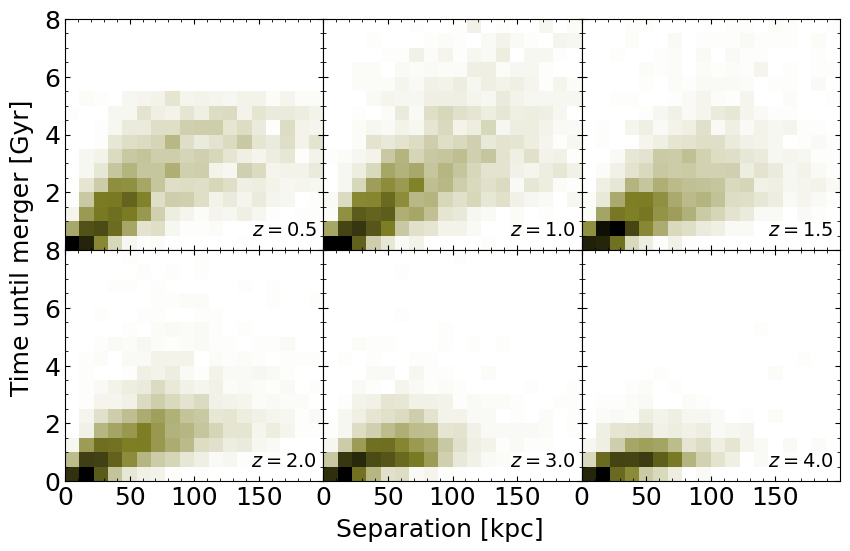

In [59]:
fig, ax = plt.subplots(2, 3, figsize=(10,6),sharey='row', sharex=True, 
                       gridspec_kw={'width_ratios': [1,1,1], 
                                    'height_ratios':[1,1],
                                    'wspace': 0.00,
                                    "hspace":0.0})
ind = 0 
rows = [0,1]
cols = [0,1,2]
snaps = [67,50,40,33,25,21]
for i in rows:
    for j in cols: 
#     for en,i in enumerate():
    # - low sep first! 
        nonzero = low['Separations'][:,snaps[ind]]!=0
        nonnan = ~np.isnan(low['Separations'][:,snaps[ind]])
        mergers = low['MergeFlag']
        afterinfall = low["InfallSnapshot"] <= snaps[ind]

        mask = nonzero&nonnan&mergers&afterinfall

        seps = low['Separations'][:,snaps[ind]][mask]
        mergesnap = low['MergeSnapshot'][mask]
        mergetimes = convert["Lookback Time"][mergesnap]
        timetilmerge = convert["Lookback Time"][snaps[ind]] - mergetimes

        print(f"Remaining pairs: {np.count_nonzero(mask)} out of {len(low['Separations'])}")

        h,_,_,im0 = ax[i][j].hist2d(seps,timetilmerge,range=[[0,200],[0,8]],bins=[int(18),int(16)],cmap=green_map,weights=np.ones(len(seps))/5798)
#         h,xedges,yedges = np.histogram2d(seps,timetilmerge,range=[[0,200],[0,8]],bins=[int(18),int(16)])
#         _,_,_,im0 = ax[i][j].hist2d(seps,timetilmerge,range=[[0,200],[0,8]],bins=[int(20),int(20)],cmap=dark_green)
#         X, Y = np.meshgrid(xedges, yedges)

#         ax[i][j].pcolormesh(X, Y, h)
#         fig.colorbar(im0, ax=ax[i][j], aspect=30, location="right",shrink=0.8,pad=0.01)
#         im.set_data()
#               ax[i][j].add_image(im)
#         ax[i][j].imshow(h)
        ax[i][j].text(195,0.5,str(r"$z=$"+f"{convert['Redshift'][snaps[ind]]:1.1f}"),
                                  ha='right',fontsize=14)
        ax[i][j].set_xticks(ticks=np.arange(0,200,50))

        ind += 1
                      
                      
                      
#         ax[en][1].text(195,0.5,str(r"$z=$"+f"{convert['Redshift'][i]:1.1f}"),ha='right',fontsize=14)                                      

#     # - colorbar 1
#     cax = fig.add_axes([0.47, 0.25, 0.01, 0.6])
#     fig1 = fig.colorbar(im0, cax=cax, aspect=30, location="left",shrink=0.8,pad=0.01)    
#     fig1.ax.tick_params(labelsize=14)

#     # - colorbar 2
#     cax = fig.add_axes([0.87, 0.25, 0.01, 0.6])
#     fig2 = fig.colorbar(im1, cax=cax,aspect=30,location="left",shrink=0.8,pad=0.01)
#     fig2.ax.tick_params(labelsize=14)

ax[0][0].set_yticks(ticks=np.arange(2,9,2))
ax[1][0].set_yticks(ticks=np.arange(0,9,2))
        
# ax[0].set_ylabel("Time until merger [Gyr]") 
# ax[0].set_title("Low-mass pairs",fontsize=18,color=palette['low']) 
# ax[1].set_title("High-mass  pairs",fontsize=18,color=palette['high']) 
fig.supxlabel(r"Separation [kpc]",fontsize=18)
fig.supylabel(r"Time until merger [Gyr]",fontsize=18,x=0.07)

# plt.savefig("../../plots/bet-on-it/3_Timevsz-2d.png")
# plt.savefig("../../plots/bet-on-it/3_Timevsseplow-2d.png")


plt.show()

# Merger time vs. redshift (lines) 

In [8]:
# let's try to be smart about this ~ 
infall = np.array(np.triu(np.zeros((100,100))+1),dtype='bool')

for dat in [low, high]:
    dat["PostInfall"] = infall[dat['InfallSnapshot']]


In [9]:
def get_median_times_all( data, convert, quantiles=[0.25,0.75]):

    nonzero = data['Separations']!=0 # n x 100
    nonnan = ~np.isnan(data['Separations']) # n x 100
    postinfall = data['PostInfall']!=0 # n x 100

    mask = nonnan&nonzero&postinfall

    seps_of_merger_pairs = np.where(mask, data['Separations'], 0)[data["MergeFlag"]]

    in_bin = (seps_of_merger_pairs>10)

    corresponding_merger_time_array = convert['Lookback Time'][data['MergeSnapshot'][data['MergeFlag']]]

    merger_time_matrix = np.tile(corresponding_merger_time_array,(100,1)).transpose()

    times_til_matrix = np.where(in_bin,convert['Lookback Time'],np.nan) - merger_time_matrix

    times_df = pd.DataFrame(times_til_matrix)

    meds = times_df.median().values
    qs = times_df.quantile(quantiles).values
    counts = times_df.count().values
    
    return counts, meds, qs

In [10]:
def H(z, OmegaM=0.31, OmegaR=0, OmegaK=0, OmegaL=0.69, H0=0.677*100 ):
    """ calculates the hubble parameter at z in km/s/Mpc"""
    A = OmegaM*(1+z)**3 # matter term
    B = OmegaR*(1+z)**4 # radiation term
    C = OmegaK*(1+z)**2 # curvature term
    D = OmegaL
    H02 = H0**2
    
    H2 = H02*(A+B+C+D)
    H1 = abs(np.sqrt(H2))
    return H1

In [11]:
def HTime(z):
    """ returns the hubble time (parameter) at z in Gyr"""
    HT_in_sMpcperkm = 1/(H(z))
    conversion_factor = 977.7922216807891 # to convert from sMpc/km to Gyr
    HT_in_Gyr = HT_in_sMpcperkm*conversion_factor
    
    return HT_in_Gyr
    

In [15]:
import astropy.units as u

In [16]:
(u.s*u.Mpc/u.km).to(u.Gyr)

977.7922216807891

In [17]:
(1/(H(0)*u.km/u.Mpc/u.s)).to(u.Gyr)

<Quantity 14.44301657 Gyr>

In [18]:
HTime(np.array([0,1,2]))

array([14.44301657,  8.11200628,  4.79837086])

In [15]:
redshifts = convert['Redshift']
hubbletime = HTime(redshifts)
hubbletime_plusone = HTime(redshifts+1)

beta = (3/np.pi/8)**0.5

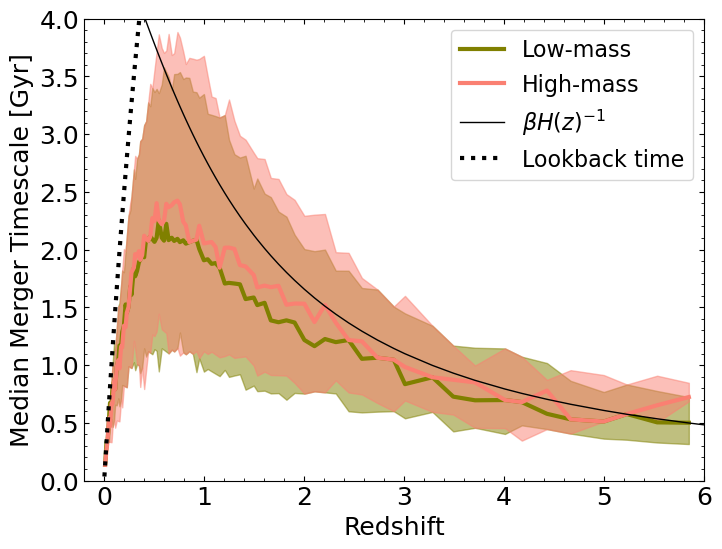

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(8,6), sharey=True, sharex=True, 
                       gridspec_kw={'width_ratios': [1], 'height_ratios':[1],
                                    'wspace': 0.02,"hspace":0.15})

ind_cut = np.where(convert['Redshift']<6)[0][0]

# low mass
counts, meds, qs = get_median_times_all( low, convert)  
plot_red = convert['Redshift'][ind_cut:]
plot_meds = meds[ind_cut:]
plot_low = qs[0][ind_cut:]
plot_high = qs[1][ind_cut:]

ax.plot(plot_red, plot_meds,color=palette["low"],lw=3,label='Low-mass')
ax.fill_between(plot_red, plot_low, plot_high,color=palette["low"],alpha=0.5)

# high mass
counts, meds, qs = get_median_times_all( high, convert)  
plot_meds = meds[ind_cut:]
plot_low = qs[0][ind_cut:]
plot_high = qs[1][ind_cut:]

ax.plot(plot_red, plot_meds,color=palette["high"],lw=3,label='High-mass')
ax.fill_between(plot_red, plot_low, plot_high,color=palette["high"],alpha=0.5)

# bounding lines
# for i in np.arange(0.4,0.6,0.05):
#     ax.plot(redshifts-1, i*hubbletime, label=r"$\frac{2}{5}H(z)^{-1}$", lw=1, color="black")
# # ax.plot(redshifts, 0.3*hubbletime, label=r"$\frac{2}{5}H(z)^{-1}$", lw=1, color="black")
# ax.plot(redshifts-1, 0.35*hubbletime, label=r"$\frac{2}{5}H(z)^{-1}$", lw=1, color="black")
# ax.plot(redshifts-1, 0.3*hubbletime, label=r"$\frac{2}{5}H(z)^{-1}$", lw=1, color="black")

ax.plot(redshifts, beta*hubbletime, label=r"$\beta H(z)^{-1}$", lw=1, color="black")
# ax.plot(redshifts, 0.4*hubbletime_plusone, label=r"$\frac{2}{5}H(z)^{-1}$", lw=1, color="black")
# ax.plot(redshifts, 0.3*hubbletime, label=r"$\frac{2}{5}H(z)^{-1}$", lw=1, color="black")
# ax.plot(redshifts-1, 0.35*hubbletime, label=r"$\frac{2}{5}H(z)^{-1}$", lw=1, color="black")
# ax.plot(redshifts-1, 0.3*hubbletime, label=r"$\frac{2}{5}H(z)^{-1}$", lw=1, color="black")

ax.plot(redshifts, convert['Lookback Time'], lw=3, linestyle='dotted', color="black", label="Lookback time")

ax.set_xlabel("Redshift",y=0.0,fontsize=18)
ax.set_ylabel("Median Merger Timescale [Gyr]",x=0.08,fontsize=18)
ax.legend(fontsize=16)
ax.set_xlim(left=-0.2,right=6)
ax.set_ylim(0,4)

plt.savefig(f"{paths.path_plots}bet-on-it/8_timescale.png",bbox_inches='tight',facecolor="white")

plt.show() 

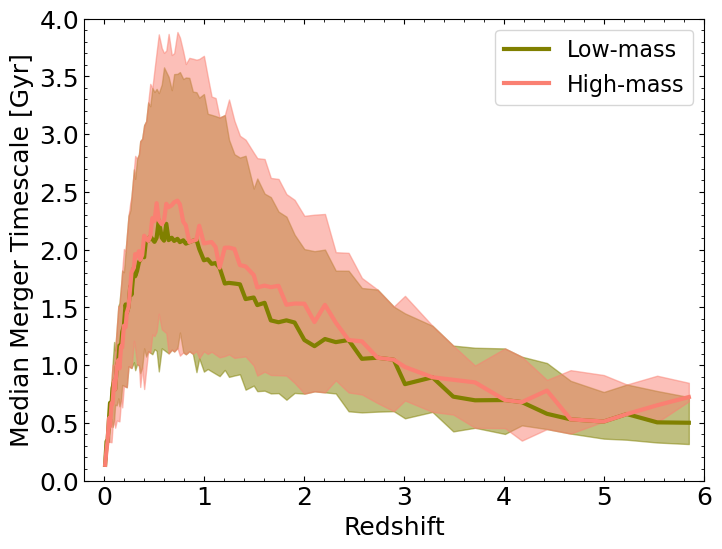

In [27]:
# to make plot without lines

fig, ax = plt.subplots(1, 1, figsize=(8,6), sharey=True, sharex=True, 
                       gridspec_kw={'width_ratios': [1], 'height_ratios':[1],
                                    'wspace': 0.02,"hspace":0.15})

ind_cut = np.where(convert['Redshift']<6)[0][0]

# low mass
counts, meds, qs = get_median_times_all( low, convert)  
plot_red = convert['Redshift'][ind_cut:]
plot_meds = meds[ind_cut:]
plot_low = qs[0][ind_cut:]
plot_high = qs[1][ind_cut:]

ax.plot(plot_red, plot_meds,color=palette["low"],lw=3,label='Low-mass')
ax.fill_between(plot_red, plot_low, plot_high,color=palette["low"],alpha=0.5)

# high mass
counts, meds, qs = get_median_times_all( high, convert)  
plot_meds = meds[ind_cut:]
plot_low = qs[0][ind_cut:]
plot_high = qs[1][ind_cut:]

ax.plot(plot_red, plot_meds,color=palette["high"],lw=3,label='High-mass')
ax.fill_between(plot_red, plot_low, plot_high,color=palette["high"],alpha=0.5)

# ax.plot(redshifts, beta*hubbletime, label=r"$\beta H(z)^{-1}$", lw=1, color="black")

# ax.plot(redshifts, convert['Lookback Time'], lw=3, linestyle='dotted', color="black", label="Lookback time")

ax.set_xlabel("Redshift",y=0.0,fontsize=18)
ax.set_ylabel("Median Merger Timescale [Gyr]",x=0.08,fontsize=18)
ax.legend(fontsize=16)
ax.set_xlim(left=-0.2,right=6)
ax.set_ylim(0,4)

plt.savefig(f"{paths.path_plots}bet-on-it/8_timescale_nolines.pdf",bbox_inches='tight',facecolor="white")

plt.show() 

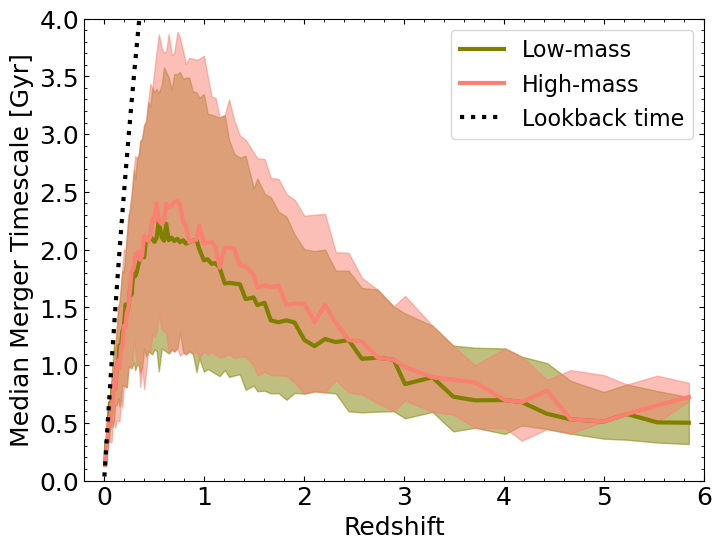

In [29]:
# to make plot without lines

fig, ax = plt.subplots(1, 1, figsize=(8,6), sharey=True, sharex=True, 
                       gridspec_kw={'width_ratios': [1], 'height_ratios':[1],
                                    'wspace': 0.02,"hspace":0.15})

ind_cut = np.where(convert['Redshift']<6)[0][0]

# low mass
counts, meds, qs = get_median_times_all( low, convert)  
plot_red = convert['Redshift'][ind_cut:]
plot_meds = meds[ind_cut:]
plot_low = qs[0][ind_cut:]
plot_high = qs[1][ind_cut:]

ax.plot(plot_red, plot_meds,color=palette["low"],lw=3,label='Low-mass')
ax.fill_between(plot_red, plot_low, plot_high,color=palette["low"],alpha=0.5)

# high mass
counts, meds, qs = get_median_times_all( high, convert)  
plot_meds = meds[ind_cut:]
plot_low = qs[0][ind_cut:]
plot_high = qs[1][ind_cut:]

ax.plot(plot_red, plot_meds,color=palette["high"],lw=3,label='High-mass')
ax.fill_between(plot_red, plot_low, plot_high,color=palette["high"],alpha=0.5)

# ax.plot(redshifts, beta*hubbletime, label=r"$\beta H(z)^{-1}$", lw=1, color="black")

ax.plot(redshifts, convert['Lookback Time'], lw=3, linestyle='dotted', color="black", label="Lookback time")

ax.set_xlabel("Redshift",y=0.0,fontsize=18)
ax.set_ylabel("Median Merger Timescale [Gyr]",x=0.08,fontsize=18)
ax.legend(fontsize=16)
ax.set_xlim(left=-0.2,right=6)
ax.set_ylim(0,4)

plt.savefig(f"{paths.path_plots}bet-on-it/8_timescale_justlbt.pdf",bbox_inches='tight',facecolor="white")

plt.show() 

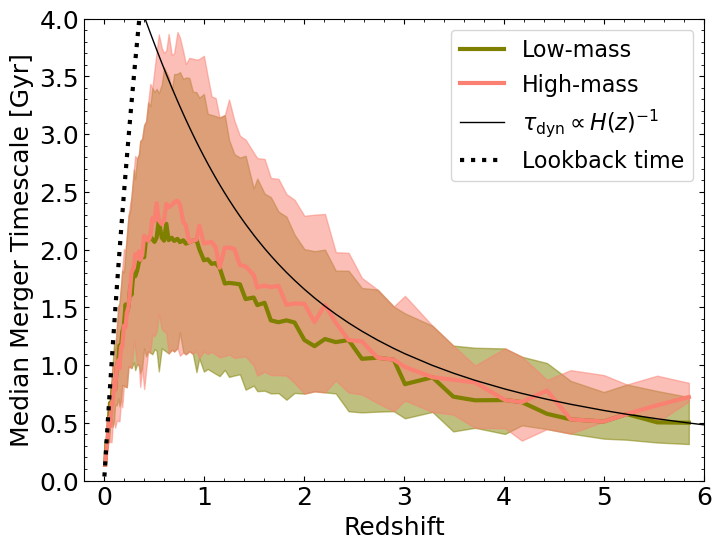

In [26]:
# to make plot without lines - dynamical time label

fig, ax = plt.subplots(1, 1, figsize=(8,6), sharey=True, sharex=True, 
                       gridspec_kw={'width_ratios': [1], 'height_ratios':[1],
                                    'wspace': 0.02,"hspace":0.15})

ind_cut = np.where(convert['Redshift']<6)[0][0]

# low mass
counts, meds, qs = get_median_times_all( low, convert)  
plot_red = convert['Redshift'][ind_cut:]
plot_meds = meds[ind_cut:]
plot_low = qs[0][ind_cut:]
plot_high = qs[1][ind_cut:]

ax.plot(plot_red, plot_meds,color=palette["low"],lw=3,label='Low-mass')
ax.fill_between(plot_red, plot_low, plot_high,color=palette["low"],alpha=0.5)

# high mass
counts, meds, qs = get_median_times_all( high, convert)  
plot_meds = meds[ind_cut:]
plot_low = qs[0][ind_cut:]
plot_high = qs[1][ind_cut:]

ax.plot(plot_red, plot_meds,color=palette["high"],lw=3,label='High-mass')
ax.fill_between(plot_red, plot_low, plot_high,color=palette["high"],alpha=0.5)

ax.plot(redshifts, beta*hubbletime, label=r"$\tau_{\rm dyn}\propto H(z)^{-1}$", lw=1, color="black")

ax.plot(redshifts, convert['Lookback Time'], lw=3, linestyle='dotted', color="black", label="Lookback time")

ax.set_xlabel("Redshift",y=0.0,fontsize=18)
ax.set_ylabel("Median Merger Timescale [Gyr]",x=0.08,fontsize=18)
ax.legend(fontsize=16)
ax.set_xlim(left=-0.2,right=6)
ax.set_ylim(0,4)

plt.savefig(f"{paths.path_plots}bet-on-it/8_timescale_modlegend.pdf",bbox_inches='tight',facecolor="white")

plt.show() 

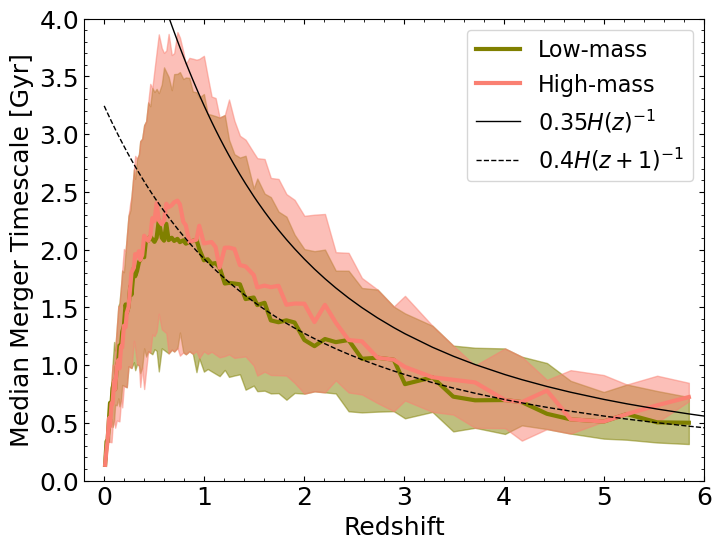

In [80]:
fig, ax = plt.subplots(1, 1, figsize=(8,6), sharey=True, sharex=True, 
                       gridspec_kw={'width_ratios': [1], 'height_ratios':[1],
                                    'wspace': 0.02,"hspace":0.15})

ind_cut = np.where(convert['Redshift']<6)[0][0]

# low mass
counts, meds, qs = get_median_times_all( low, convert)  
plot_red = convert['Redshift'][ind_cut:]
plot_meds = meds[ind_cut:]
plot_low = qs[0][ind_cut:]
plot_high = qs[1][ind_cut:]

ax.plot(plot_red, plot_meds,color=palette["low"],lw=3,label='Low-mass')
ax.fill_between(plot_red, plot_low, plot_high,color=palette["low"],alpha=0.5)

# high mass
counts, meds, qs = get_median_times_all( high, convert)  
plot_meds = meds[ind_cut:]
plot_low = qs[0][ind_cut:]
plot_high = qs[1][ind_cut:]

ax.plot(plot_red, plot_meds,color=palette["high"],lw=3,label='High-mass')
ax.fill_between(plot_red, plot_low, plot_high,color=palette["high"],alpha=0.5)

# bounding lines
# for i in np.arange(0.4,0.6,0.05):
#     ax.plot(redshifts-1, i*hubbletime, label=r"$\frac{2}{5}H(z)^{-1}$", lw=1, color="black")
# # ax.plot(redshifts, 0.3*hubbletime, label=r"$\frac{2}{5}H(z)^{-1}$", lw=1, color="black")
# ax.plot(redshifts-1, 0.35*hubbletime, label=r"$\frac{2}{5}H(z)^{-1}$", lw=1, color="black")
# ax.plot(redshifts-1, 0.3*hubbletime, label=r"$\frac{2}{5}H(z)^{-1}$", lw=1, color="black")

ax.plot(redshifts, 0.4*hubbletime, label=r"$0.35 H(z)^{-1}$", lw=1, color="black")
ax.plot(redshifts, 0.4*hubbletime_plusone, label=r"$0.4H(z+1)^{-1}$", lw=1, linestyle='dashed',color="black")
# ax.plot(redshifts, 0.4*hubbletime_plusone, label=r"$\frac{2}{5}H(z)^{-1}$", lw=1, color="black")
# ax.plot(redshifts, 0.3*hubbletime, label=r"$\frac{2}{5}H(z)^{-1}$", lw=1, color="black")
# ax.plot(redshifts-1, 0.35*hubbletime, label=r"$\frac{2}{5}H(z)^{-1}$", lw=1, color="black")
# ax.plot(redshifts-1, 0.3*hubbletime, label=r"$\frac{2}{5}H(z)^{-1}$", lw=1, color="black")

# ax.plot(redshifts, convert['Lookback Time'], lw=3, linestyle='dotted', color="black", label="Lookback time")

ax.set_xlabel("Redshift",y=0.0,fontsize=18)
ax.set_ylabel("Median Merger Timescale [Gyr]",x=0.08,fontsize=18)
ax.legend(fontsize=16)
ax.set_xlim(left=-0.2,right=6)
ax.set_ylim(0,4)

plt.savefig(f"{paths.path_plots}bet-on-it/8_timescale_betterfit.png",bbox_inches='tight',facecolor="white")

plt.show() 

# Merger time vs. redshift - separation selections

In [31]:
def get_median_times( data, convert, sep_lim, quantiles=[0.25,0.75]):

    nonzero = data['Separations']!=0 # n x 100
    nonnan = ~np.isnan(data['Separations']) # n x 100
    postinfall = data['PostInfall']!=0 # n x 100

    mask = nonnan&nonzero&postinfall

    seps_of_merger_pairs = np.where(mask, data['Separations'], 0)[data["MergeFlag"]]

    in_bin = (seps_of_merger_pairs>10)&(seps_of_merger_pairs < sep_lim)

    corresponding_merger_time_array = convert['Lookback Time'][data['MergeSnapshot'][data['MergeFlag']]]

    merger_time_matrix = np.tile(corresponding_merger_time_array,(100,1)).transpose()

    times_til_matrix = np.where(in_bin,convert['Lookback Time'],np.nan) - merger_time_matrix

    times_df = pd.DataFrame(times_til_matrix)

    meds = times_df.median().values
    qs = times_df.quantile(quantiles).values
    counts = times_df.count().values
    
    return counts, meds, qs

In [32]:
def get_median_times_scaled( data, convert, scsep_lim, quantiles=[0.25,0.75]):

    nonzero = data['Separations']!=0 # n x 100
    nonnan = ~np.isnan(data['Separations']) # n x 100
    postinfall = data['PostInfall']!=0 # n x 100

    mask = nonnan&nonzero&postinfall

    seps_of_merger_pairs = np.where(mask, data['Separations'], 0)[data["MergeFlag"]]
    scseps_of_merger_pairs = np.where(mask, data['SeparationsScaled'], 0)[data["MergeFlag"]]

    in_bin = (seps_of_merger_pairs>10)&(scseps_of_merger_pairs < scsep_lim)

    corresponding_merger_time_array = convert['Lookback Time'][data['MergeSnapshot'][data['MergeFlag']]]

    merger_time_matrix = np.tile(corresponding_merger_time_array,(100,1)).transpose()

    times_til_matrix = np.where(in_bin,convert['Lookback Time'],np.nan) - merger_time_matrix

    times_df = pd.DataFrame(times_til_matrix)

    meds = times_df.median().values
    qs = times_df.quantile(quantiles).values
    counts = times_df.count().values
    
    return counts, meds, qs

In [33]:
redshifts = convert['Redshift']
hubbletime = HTime(redshifts)

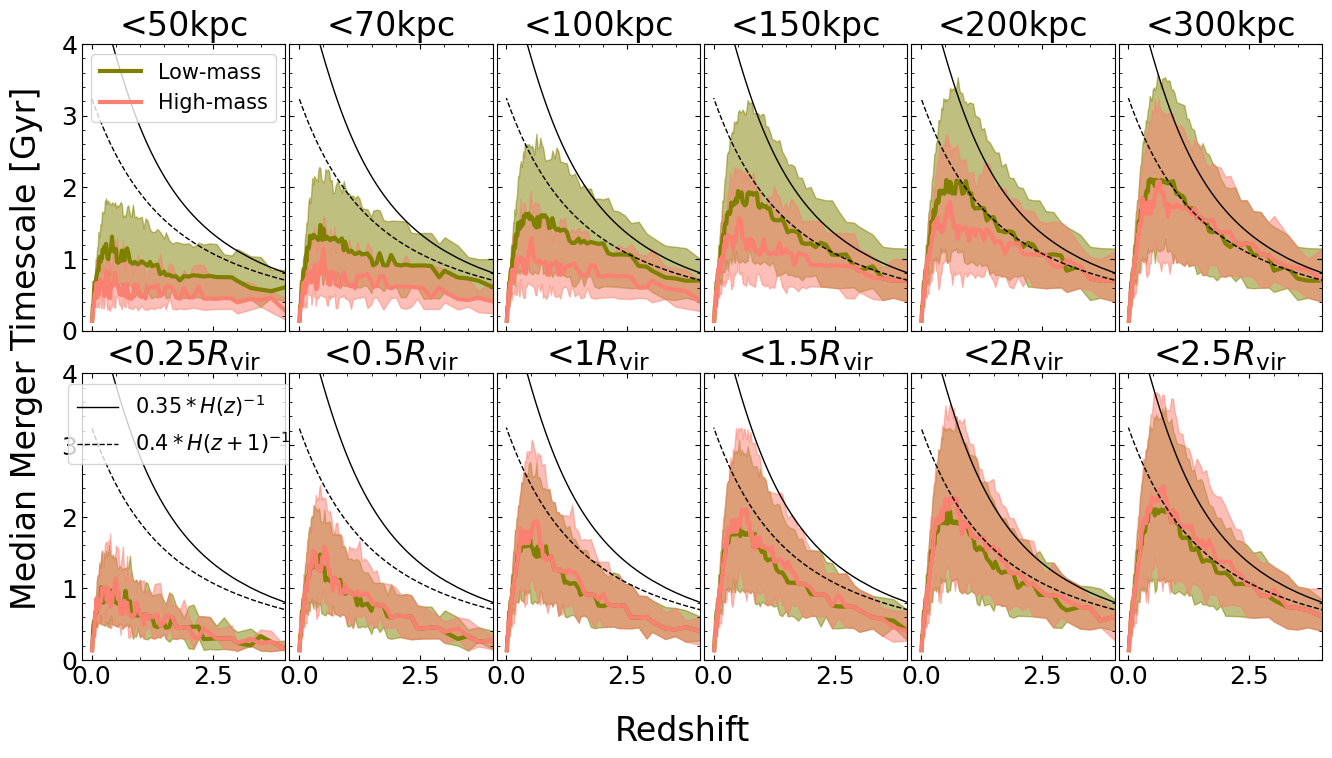

In [91]:
sepcut = [50,70,100,150, 200, 300]
vircut = [0.25,0.5,1,1.5,2, 2.5]
ind_cut = np.where(convert['Redshift']<4.2)[0][0]

fig, ax = plt.subplots(2, 6, figsize=(16,8), sharey=True, sharex=True, 
                       gridspec_kw={'width_ratios': [1,1,1,1,1,1], 'height_ratios':[1,1],
                                    'wspace': 0.02,"hspace":0.15})

for ind in range(6):
    plot_red = convert['Redshift'][ind_cut:]
    
    ### physical separation cuts
    ax[0][ind].set(title=f"<{sepcut[ind]}kpc")

    
    counts, meds, qs = get_median_times( low, convert, sepcut[ind])  
    
    ax[0][ind].plot(plot_red, meds[ind_cut:],lw=3,color=palette['low'],label='Low-mass')
    ax[0][ind].fill_between(plot_red, qs[0][ind_cut:], qs[1][ind_cut:],color=palette["low"],alpha=0.5)
    
    counts, meds, qs = get_median_times( high, convert, sepcut[ind])
    
    ax[0][ind].plot(plot_red, meds[ind_cut:],lw=3,color=palette['high'],label='High-mass')
    ax[0][ind].fill_between(plot_red, qs[0][ind_cut:], qs[1][ind_cut:],color=palette["high"],alpha=0.5)


#     ax[1][ind].plot(redshifts, vircut[ind]*2/5*hubbletime,color = 'grey',lw=1)

    
    ### rvir separation cuts
    ax[1][ind].set(title=f"<{vircut[ind]}"+r"$R_{\rm vir}$")
    
    counts, meds, qs = get_median_times_scaled( low, convert, vircut[ind])  
    
    ax[1][ind].plot(plot_red,meds[ind_cut:],lw=3,color=palette['low'])
    ax[1][ind].fill_between(plot_red, qs[0][ind_cut:], qs[1][ind_cut:],color=palette["low"],alpha=0.5)
 
    counts, meds, qs = get_median_times_scaled( high, convert, vircut[ind])  
    
    ax[1][ind].plot(plot_red, meds[ind_cut:],lw=3,color=palette['high'])
    ax[1][ind].fill_between(plot_red, qs[0][ind_cut:], qs[1][ind_cut:],color=palette["high"],alpha=0.5)
#     ax[1][ind].scatter([1],lows[ind])
    
    # toggle for change line from z to z+1
#     ax[1][ind].plot(redshifts, 2/5*hubbletime,color = 'black',lw=1)
    ax[0][ind].plot(redshifts, 0.4*hubbletime_plusone, lw=1, linestyle='dashed',color="black")
    ax[0][ind].plot(redshifts, 0.35*hubbletime, lw=1, color="black")
    ax[1][ind].plot(redshifts, 0.4*hubbletime_plusone, lw=1, linestyle='dashed',color="black")
    ax[1][ind].plot(redshifts, 0.35*hubbletime, lw=1, color="black")

#     ax[1][ind].plot(redshifts, vircut[ind]*1/4*hubbletime,color = 'grey',lw=1)
    
#############
#############


# ax[0][0].plot(plot_red, meds[ind_cut:],lw=3,color=palette['high'],label='High-mass')
# ax[0][0].fill_between(plot_red, qs[0][ind_cut:], qs[1][ind_cut:],color=palette["high"],alpha=0.5)
ax[0][0].plot(0, 0, lw=1, color="black")
ax[1][0].plot(0, 0, label=r"$0.35*H(z)^{-1}$", lw=1, color="black")
ax[1][0].plot(0, 0, label=r"$0.4*H(z+1)^{-1}$", linestyle='dashed',lw=1, color="black")


ax[0][0].set_xlim(left=-0.2,right=4)
ax[0][0].set_ylim(0,4)

ax[0][0].legend(fontsize=15,loc='upper center')
ax[1][0].legend(fontsize=15,loc='upper center')
fig.supxlabel("Redshift",y=0.0)
fig.supylabel("Median Merger Timescale [Gyr]",x=0.08)

# if save:
# plt.savefig(f"{paths.path_plots}bet-on-it/8_timescale_sepcut.png",bbox_inches='tight',facecolor="white")
plt.show()

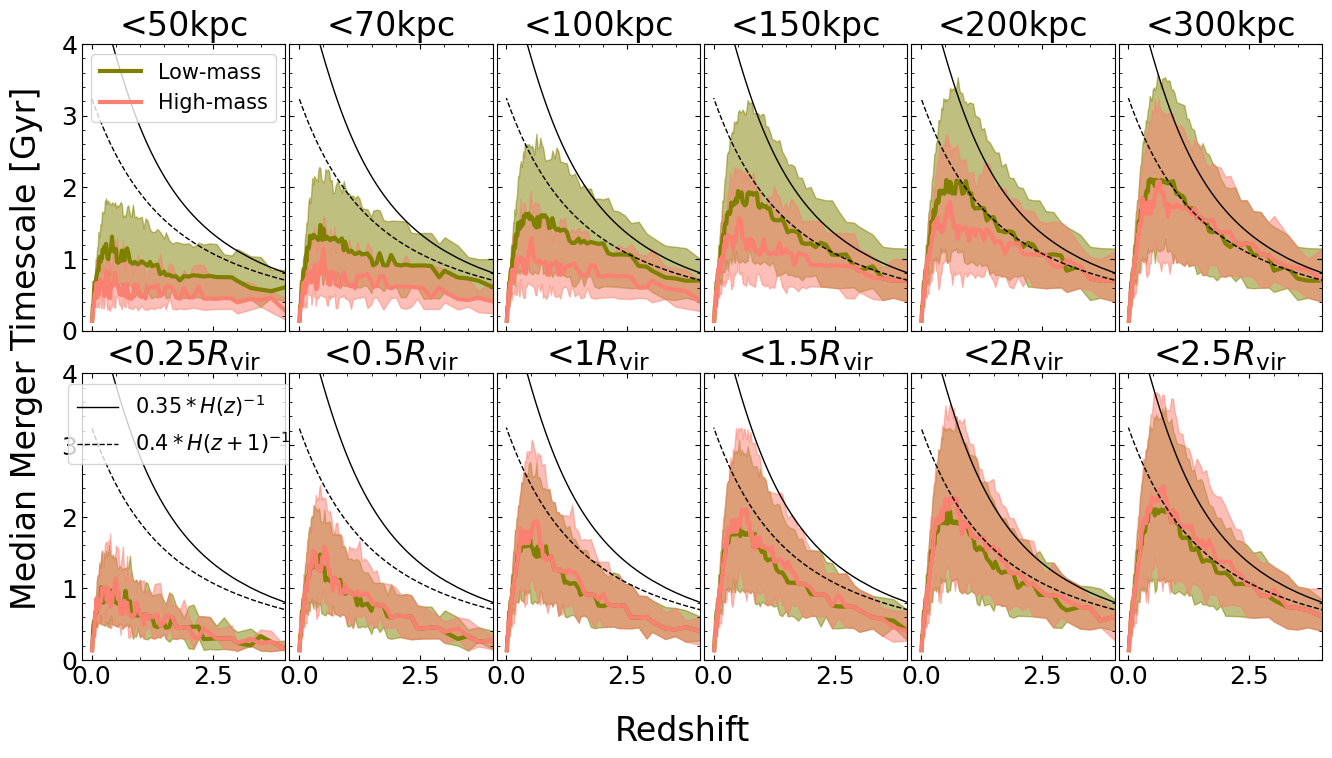

In [93]:
sepcut = [50,70,100,150, 200, 300]
vircut = [0.25,0.5,1,1.5,2, 2.5]
ind_cut = np.where(convert['Redshift']<4.2)[0][0]

fig, ax = plt.subplots(2, 6, figsize=(16,8), sharey=True, sharex=True, 
                       gridspec_kw={'width_ratios': [1,1,1,1,1,1], 'height_ratios':[1,1],
                                    'wspace': 0.02,"hspace":0.15})

for ind in range(6):
    plot_red = convert['Redshift'][ind_cut:]
    
    ### physical separation cuts
    ax[0][ind].set(title=f"<{sepcut[ind]}kpc")

    
    counts, meds, qs = get_median_times( low, convert, sepcut[ind])  
    
    ax[0][ind].plot(plot_red, meds[ind_cut:],lw=3,color=palette['low'],label='Low-mass')
    ax[0][ind].fill_between(plot_red, qs[0][ind_cut:], qs[1][ind_cut:],color=palette["low"],alpha=0.5)
    
    counts, meds, qs = get_median_times( high, convert, sepcut[ind])
    
    ax[0][ind].plot(plot_red, meds[ind_cut:],lw=3,color=palette['high'],label='High-mass')
    ax[0][ind].fill_between(plot_red, qs[0][ind_cut:], qs[1][ind_cut:],color=palette["high"],alpha=0.5)


#     ax[1][ind].plot(redshifts, vircut[ind]*2/5*hubbletime,color = 'grey',lw=1)

    
    ### rvir separation cuts
    ax[1][ind].set(title=f"<{vircut[ind]}"+r"$R_{\rm vir}$")
    
    counts, meds, qs = get_median_times_scaled( low, convert, vircut[ind])  
    
    ax[1][ind].plot(plot_red,meds[ind_cut:],lw=3,color=palette['low'])
    ax[1][ind].fill_between(plot_red, qs[0][ind_cut:], qs[1][ind_cut:],color=palette["low"],alpha=0.5)
 
    counts, meds, qs = get_median_times_scaled( high, convert, vircut[ind])  
    
    ax[1][ind].plot(plot_red, meds[ind_cut:],lw=3,color=palette['high'])
    ax[1][ind].fill_between(plot_red, qs[0][ind_cut:], qs[1][ind_cut:],color=palette["high"],alpha=0.5)
#     ax[1][ind].scatter([1],lows[ind])
    
    # toggle for change line from z to z+1
#     ax[1][ind].plot(redshifts, 2/5*hubbletime,color = 'black',lw=1)
    ax[0][ind].plot(redshifts, 0.4*hubbletime_plusone, lw=1, linestyle='dashed',color="black")
    ax[0][ind].plot(redshifts, 0.35*hubbletime, lw=1, color="black")
    ax[1][ind].plot(redshifts, 0.4*hubbletime_plusone, lw=1, linestyle='dashed',color="black")
    ax[1][ind].plot(redshifts, 0.35*hubbletime, lw=1, color="black")

#     ax[1][ind].plot(redshifts, vircut[ind]*1/4*hubbletime,color = 'grey',lw=1)
    
#############
#############


# ax[0][0].plot(plot_red, meds[ind_cut:],lw=3,color=palette['high'],label='High-mass')
# ax[0][0].fill_between(plot_red, qs[0][ind_cut:], qs[1][ind_cut:],color=palette["high"],alpha=0.5)
ax[0][0].plot(0, 0, lw=1, color="black")
ax[1][0].plot(0, 0, label=r"$0.35*H(z)^{-1}$", lw=1, color="black")
ax[1][0].plot(0, 0, label=r"$0.4*H(z+1)^{-1}$", linestyle='dashed',lw=1, color="black")


ax[0][0].set_xlim(left=-0.2,right=4)
ax[0][0].set_ylim(0,4)

ax[0][0].legend(fontsize=15,loc='upper center')
ax[1][0].legend(fontsize=15,loc='upper center')
fig.supxlabel("Redshift",y=0.0)
fig.supylabel("Median Merger Timescale [Gyr]",x=0.08)

# if save:
plt.savefig(f"{paths.path_plots}bet-on-it/8_timescale_sepcut_betterfit.png",bbox_inches='tight',facecolor="white")
plt.show()

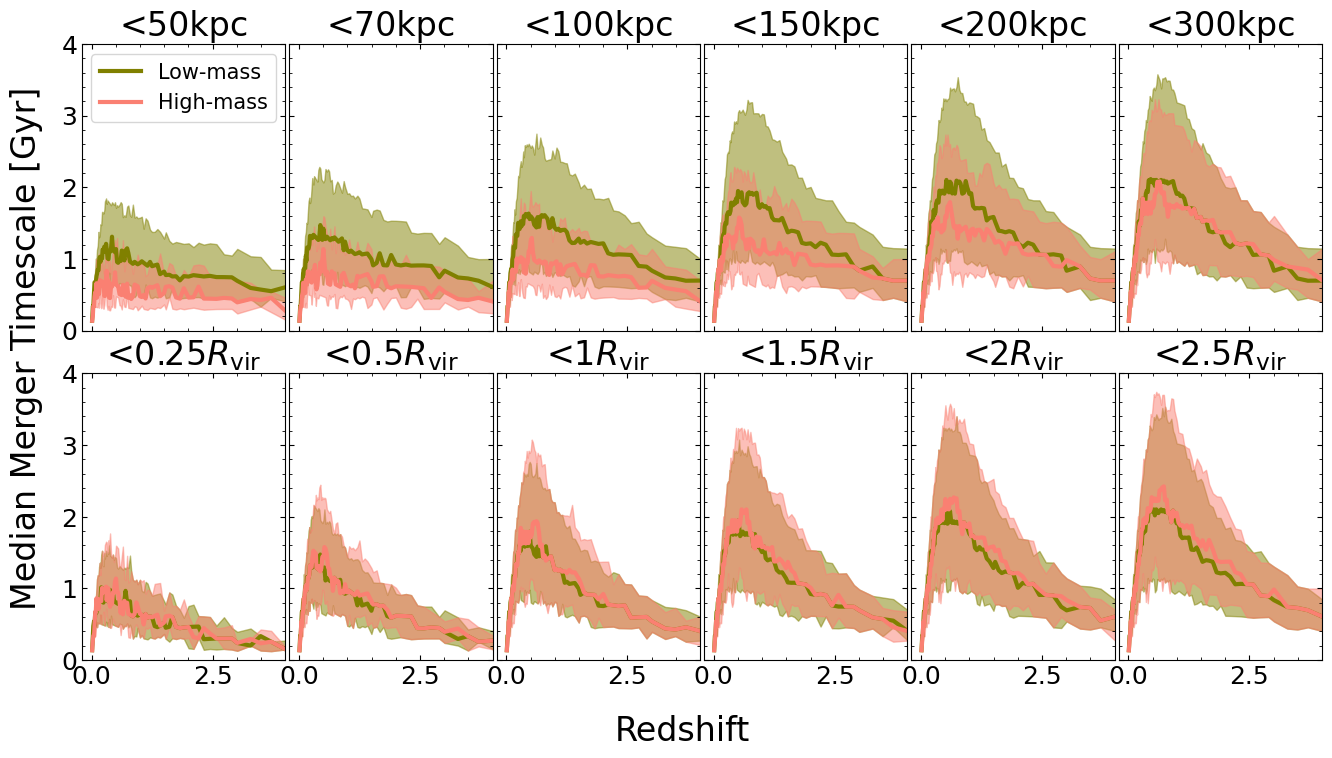

In [36]:
# pdf version no lines
sepcut = [50,70,100,150, 200, 300]
vircut = [0.25,0.5,1,1.5,2, 2.5]
ind_cut = np.where(convert['Redshift']<4.2)[0][0]

fig, ax = plt.subplots(2, 6, figsize=(16,8), sharey=True, sharex=True, 
                       gridspec_kw={'width_ratios': [1,1,1,1,1,1], 'height_ratios':[1,1],
                                    'wspace': 0.02,"hspace":0.15})

for ind in range(6):
    plot_red = convert['Redshift'][ind_cut:]
    
    ### physical separation cuts
    ax[0][ind].set(title=f"<{sepcut[ind]}kpc")

    
    counts, meds, qs = get_median_times( low, convert, sepcut[ind])  
    
    ax[0][ind].plot(plot_red, meds[ind_cut:],lw=3,color=palette['low'],label='Low-mass')
    ax[0][ind].fill_between(plot_red, qs[0][ind_cut:], qs[1][ind_cut:],color=palette["low"],alpha=0.5)
    
    counts, meds, qs = get_median_times( high, convert, sepcut[ind])
    
    ax[0][ind].plot(plot_red, meds[ind_cut:],lw=3,color=palette['high'],label='High-mass')
    ax[0][ind].fill_between(plot_red, qs[0][ind_cut:], qs[1][ind_cut:],color=palette["high"],alpha=0.5)


#     ax[1][ind].plot(redshifts, vircut[ind]*2/5*hubbletime,color = 'grey',lw=1)

    
    ### rvir separation cuts
    ax[1][ind].set(title=f"<{vircut[ind]}"+r"$R_{\rm vir}$")
    
    counts, meds, qs = get_median_times_scaled( low, convert, vircut[ind])  
    
    ax[1][ind].plot(plot_red,meds[ind_cut:],lw=3,color=palette['low'])
    ax[1][ind].fill_between(plot_red, qs[0][ind_cut:], qs[1][ind_cut:],color=palette["low"],alpha=0.5)
 
    counts, meds, qs = get_median_times_scaled( high, convert, vircut[ind])  
    
    ax[1][ind].plot(plot_red, meds[ind_cut:],lw=3,color=palette['high'])
    ax[1][ind].fill_between(plot_red, qs[0][ind_cut:], qs[1][ind_cut:],color=palette["high"],alpha=0.5)
#     ax[1][ind].scatter([1],lows[ind])
    
    # toggle for change line from z to z+1
#     ax[1][ind].plot(redshifts, 2/5*hubbletime,color = 'black',lw=1)
#     ax[0][ind].plot(redshifts, 0.4*hubbletime_plusone, lw=1, linestyle='dashed',color="black")
#     ax[0][ind].plot(redshifts, 0.35*hubbletime, lw=1, color="black")
#     ax[1][ind].plot(redshifts, 0.4*hubbletime_plusone, lw=1, linestyle='dashed',color="black")
#     ax[1][ind].plot(redshifts, 0.35*hubbletime, lw=1, color="black")

#     ax[1][ind].plot(redshifts, vircut[ind]*1/4*hubbletime,color = 'grey',lw=1)
    
#############
#############


# ax[0][0].plot(plot_red, meds[ind_cut:],lw=3,color=palette['high'],label='High-mass')
# ax[0][0].fill_between(plot_red, qs[0][ind_cut:], qs[1][ind_cut:],color=palette["high"],alpha=0.5)
# ax[0][0].plot(0, 0, lw=1, color="black")
# ax[1][0].plot(0, 0, label=r"$0.35*H(z)^{-1}$", lw=1, color="black")
# ax[1][0].plot(0, 0, label=r"$0.4*H(z+1)^{-1}$", linestyle='dashed',lw=1, color="black")


ax[0][0].set_xlim(left=-0.2,right=4)
ax[0][0].set_ylim(0,4)

ax[0][0].legend(fontsize=15,loc='upper center')
# ax[1][0].legend(fontsize=15,loc='upper center')
fig.supxlabel("Redshift",y=0.0)
fig.supylabel("Median Merger Timescale [Gyr]",x=0.08)

# if save:
plt.savefig(f"{paths.path_plots}bet-on-it/8_timescale_sepcut_nolines.pdf",bbox_inches='tight',facecolor="white")
plt.show()

In [203]:
get_median_times_scaled(low, convert, 0.25)

(array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   2,   0,   3,  16,  11,  28,  38,  67,  97, 134, 162,
        172, 248, 292, 333, 363, 442, 492, 546, 610, 662, 661, 714, 736,
        722, 755, 769, 796, 796, 727, 784, 791, 780, 764, 737, 800, 749,
        780, 811, 775, 785, 711, 726, 733, 732, 727, 758, 709, 736, 733,
        745, 701, 673, 661, 615, 620, 596, 605, 636, 604, 618, 592, 562,
        552, 514, 513, 481, 466, 501, 497, 491, 464, 436, 413, 409, 347,
        344, 284, 240, 193, 139,  90,  65,  20,   0]),
 array([       nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
        0.14097238,        nan, 0.18868781, 0.18438384, 0.17445569,
        0.22246233, 0.14810677, 0.25567225, 0.33348086, 0.20121333,
        0.23816899, 0.30087255, 0.3010354 , 0.30006087, 0.29582831,
        0.29027134, 0.4669

In [202]:
get_median_times_scaled(high, convert, 0.25)

(array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   1,   0,   0,   3,   3,   5,   8,  10,  12,  14,  14,
         28,  47,  38,  46,  60,  58,  55,  71,  92,  98,  97,  88, 121,
        142, 133, 143, 119, 130, 169, 171, 179, 188, 183, 189, 179, 178,
        198, 192, 204, 219, 202, 190, 180, 199, 198, 200, 194, 185, 169,
        169, 189, 197, 199, 186, 195, 200, 212, 211, 216, 192, 174, 162,
        149, 154, 162, 163, 157, 165, 165, 160, 155, 159, 148, 135, 125,
        113,  96,  90,  65,  55,  33,  26,   5,   0]),
 array([       nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
        0.14097238,        nan,        nan, 0.18438384, 0.32256246,
        0.22246233, 0.14810677, 0.25567225, 0.23287419, 0.29355735,
        0.23816899, 0.30087255, 0.3010354 , 0.30006087, 0.37008635,
        0.44582282, 0.3040

In [199]:
_, meds_low, _ = get_median_times_scaled( low, convert, 0.25)
_, meds_high, _ = get_median_times_scaled( high, convert, 0.25)


In [205]:
meds_low[50]

0.6440461522708718

In [201]:
meds_high

array([       nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
       0.14097238,        nan,        nan, 0.18438384, 0.32256246,
       0.22246233, 0.14810677, 0.25567225, 0.23287419, 0.29355735,
       0.23816899, 0.30087255, 0.3010354 , 0.30006087, 0.37008635,
       0.44582282, 0.30406757, 0.31841708, 0.4598928 , 0.45435854,
       0.44449892, 0.46178676, 0.59998881, 0.61893946, 0.60975179,
       0.52300691, 0.47857398, 0.6322294 , 0.61507665, 0.59637144,
       0.61032415, 0.58937479, 0.64232841, 0.49667805, 0.63018474,
       0.64404615, 0.74819212, 0.80442857, 0.64169027, 0.60979517,
       0.62229228, 0.63169471, 0.64426066, 0.79951537, 0.76507878,
       0.82627136, 0.63770144, 0.80100285, 0.65518762, 0.82243737,
       0.9451876 , 0.95709009, 1.13724399, 1.09396873, 0.93542966,
       0.94640205, 0.78391351, 0.79284238, 0.74307338, 0.81045

In [196]:
lows = [get_median_times_scaled( low, convert, cut)[2][50] for cut in vircut]

IndexError: index 50 is out of bounds for axis 0 with size 2

In [197]:
highs = [get_median_times_scaled( high, convert, cut)[2][50] for cut in vircut]

IndexError: index 50 is out of bounds for axis 0 with size 2

In [193]:
for i in range(6):
    print(f"Low: {vircut[i]} has time {lows[i]}")

Low: 0.25 has time 0.6440461522708718
Low: 0.5 has time 0.9434863403530791
Low: 1 has time 1.2538413219216373
Low: 1.5 has time 1.5056484449234553
Low: 2 has time 1.7637509586582008
Low: 2.5 has time 1.9075414634083172


In [194]:
for i in range(6):
    print(f"High: {vircut[i]} has time {highs[i]}")

High: 0.25 has time 0.6440461522708718
High: 0.5 has time 0.9434863403530791
High: 1 has time 1.2538413219216373
High: 1.5 has time 1.5751810453718713
High: 2 has time 1.9075414634083172
High: 2.5 has time 2.0533566954662454
